Find clusters for the included dataset.
The solution must be produced as a Python Notebook. 
The notebook must include appropriate comments and must operate as follows:
1. load the data and separate in X all the columns but the last one, in y the last column, then produce a pairplot of X and comment what you see
(2pt)

In [128]:
import pandas as pd

df = pd.read_csv("exam_data.csv")

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print("Shapes:", X.shape)
print("Null rows:", X.shape[0] - X.dropna().shape[0])
print("Duplicated rows:", X.shape[0] - X.duplicated().shape[0])
display(X.info())
display(X.head(5))
display(X.describe())

Shapes: (1000, 3)
Null rows: 0
Duplicated rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A0      1000 non-null   float64
 1   A1      1000 non-null   float64
 2   A2      1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


None

,A0,A1,A2
0,2067.582042,-15.259519,0.020472
1,1319.589579,-18.412320,0.521308
2,1170.212183,-19.470602,0.814986
3,1424.162191,9.867841,0.848751
4,1551.069098,11.809364,0.884964


,A0,A1,A2
count,1000.000000,1000.000000,1000.000000
mean,1489.096297,-7.166652,0.505010
std,274.553828,13.077564,0.293416
min,690.679955,-22.833984,0.000412
25%,1295.382256,-17.161708,0.246973
50%,1495.200642,-14.249017,0.518429
75%,1676.991938,9.600518,0.766703
max,2185.753771,17.595486,0.999833


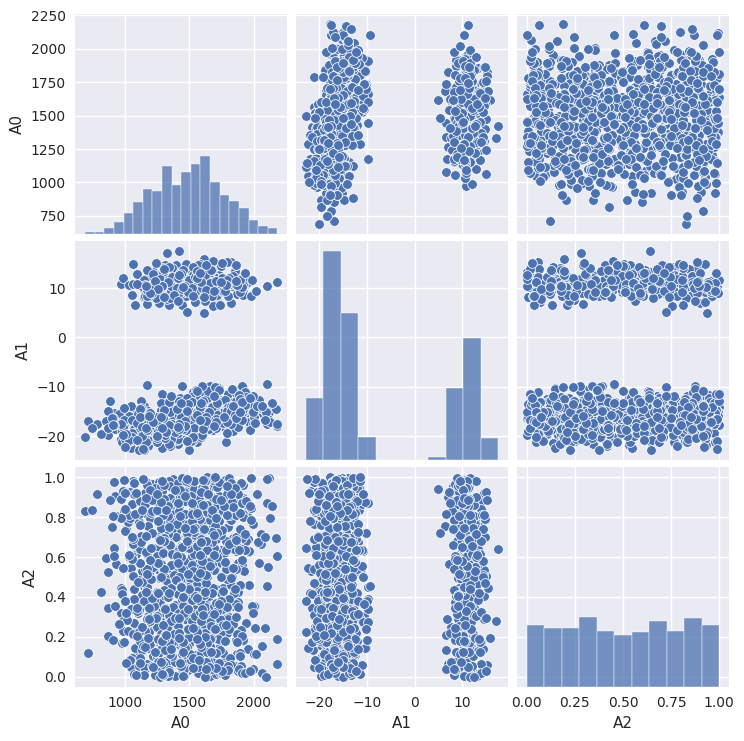

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

sns.pairplot(X)

<Axes: >

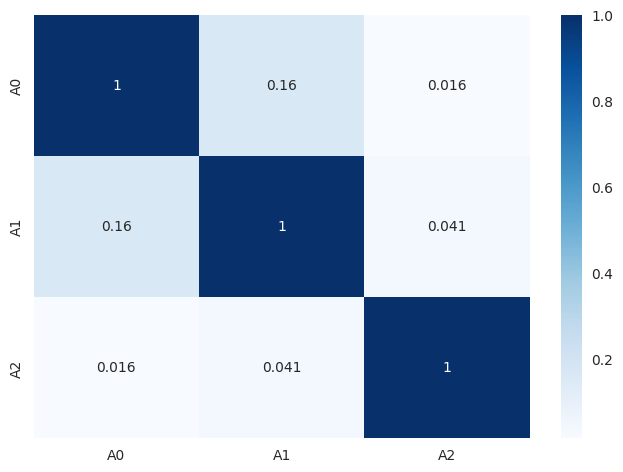

In [130]:
sns.heatmap(X.corr().abs(), annot=True, cmap="Blues")

The dataset has 0 null or duplicated rows.
All data is float, but with very different ranges. A scaling could be helpful.
A0 has a normal distribution.
A1 has two different separated normal curves.
A2 has a uniform distribution.
They all are not much correlated

2. find the best clustering scheme for X with a method of your choice, plot the silhouette index for an appropriate range of parameters and show the chosen hyperparameter(s)
(4pt)
    1. consider carefully the number of clusters, simple optimisation of the silhouette will not be enough, decide visually the best number of clusters

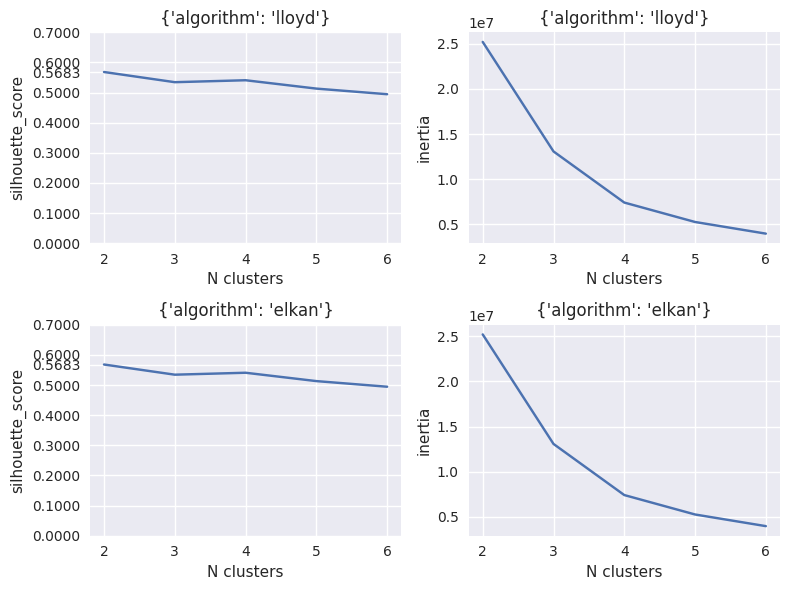

In [145]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import numpy as np


param_grid = ParameterGrid(param_grid={"algorithm": ["lloyd", "elkan"]})

clusters_range = range(2, 7)

_, ax = plt.subplots(len(list(param_grid)), 2, figsize=(8, 6))

for i, params in enumerate(list(param_grid)):
    scores = []
    inertia = []
    for clusters in clusters_range:
        gm = KMeans(
            algorithm=params["algorithm"],
            n_clusters=clusters,
            n_init=100,
            random_state=1,
        )
        gm.fit(X)
        scores.append(silhouette_score(X, gm.predict(X)))
        inertia.append(gm.inertia_)

    ax[i, 0].plot(clusters_range, scores), ax[i, 1].plot(clusters_range, inertia),
    ax[i, 0].set_title(params), ax[i, 1].set_title(params),
    ax[i, 0].set_xlabel("N clusters"), ax[i, 1].set_xlabel("N clusters")
    ax[i, 0].set_ylabel("silhouette_score"), ax[i, 1].set_ylabel("inertia"),
    ax[i, 0].set_yticks([*np.arange(0, 0.8, 0.1), max(scores)])
plt.tight_layout()
plt.show()

The optimal value seems to be 4 clusters with configuration: "lloyd"

3. fit the clustering scheme, store the cluster labels in y_km and output the silhouette score
(2pt)

In [162]:
gm = KMeans(n_clusters=3, algorithm="lloyd", n_init=100, random_state=1)
y_km = gm.fit_predict(X)
print("silhouette_score of best model", silhouette_score(X, y_km))

silhouette_score of best model 0.5345214132703076


4. use labels in last column of input file as “gold standard” for clustering & quantify matching among two clustering schemes w/ sklearn.metrics.cluster.pair_confusion_matrix
(2pt)

In [163]:
from sklearn.metrics import pair_confusion_matrix


pcm = pair_confusion_matrix(labels_true=y, labels_pred=y_km)
print(
    "The percentage of match: {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum() * 100)
)

The percentage of match:  63.63%


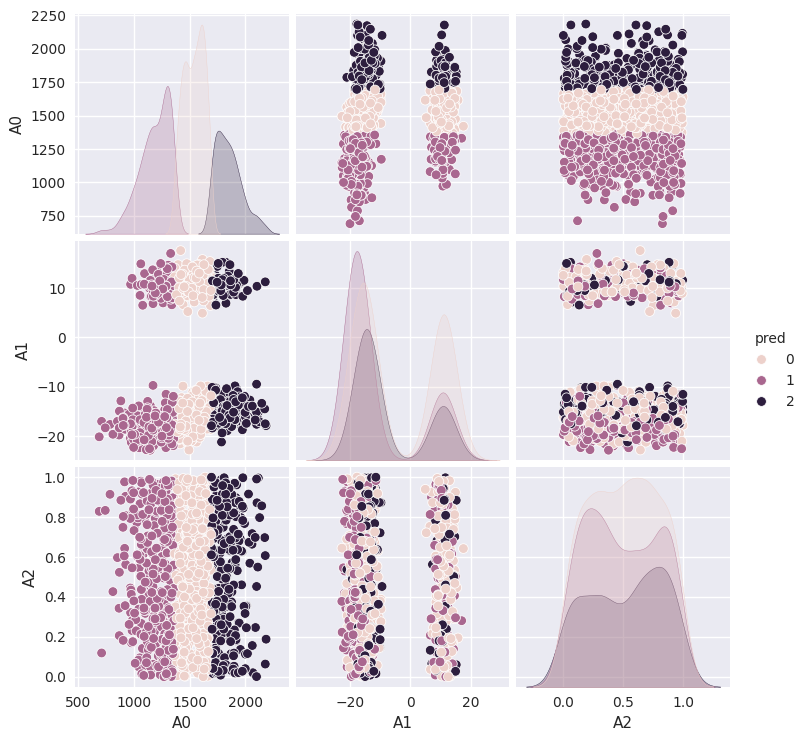

In [164]:
sns.pairplot(X.assign(pred=y_km), hue="pred")

5. consider possible pre-processing actions repeat fitting & evaluate as before result new fitting
(5pt)

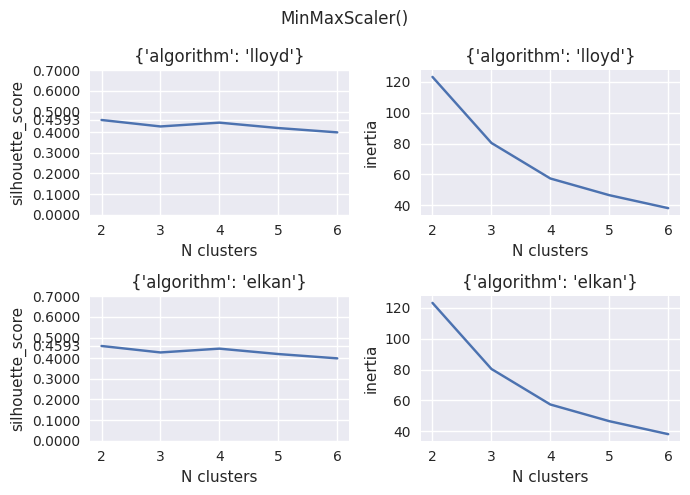

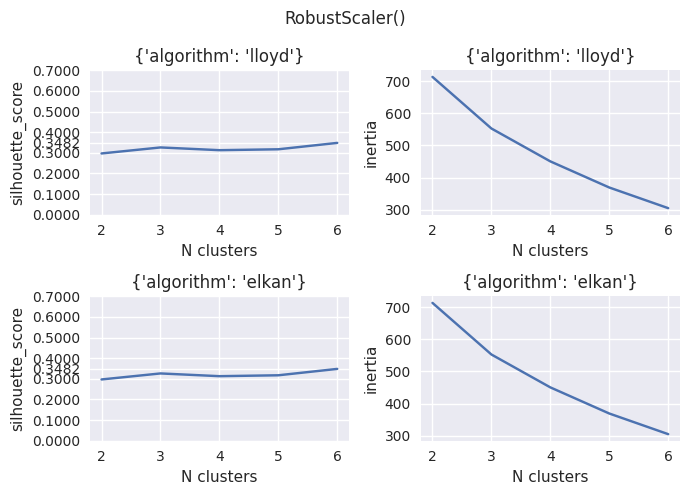

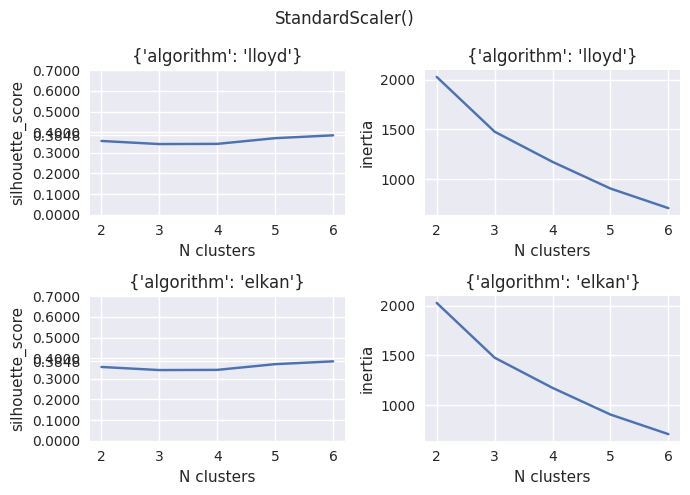

In [165]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler

transformers = [MinMaxScaler(), RobustScaler(), StandardScaler()]

param_grid = ParameterGrid(param_grid={"algorithm": ["lloyd", "elkan"]})

clusters_range = range(2, 7)

best_sil = 0
best_params = {}

for transf in transformers:
    fig, ax = plt.subplots(len(list(param_grid)), 2, figsize=(7, 5))
    X_t = transf.fit_transform(X)
    for i, params in enumerate(list(param_grid)):
        scores = []
        inertia = []
        for clusters in clusters_range:
            gm = KMeans(
                algorithm=params["algorithm"],
                n_clusters=clusters,
                n_init=100,
                random_state=1,
            )
            gm.fit(X_t)
            sil = silhouette_score(X_t, gm.predict(X_t))
            scores.append(sil)
            inertia.append(gm.inertia_)

        ax[i, 0].plot(clusters_range, scores), ax[i, 1].plot(clusters_range, inertia),
        ax[i, 0].set_title(params), ax[i, 1].set_title(params),
        ax[i, 0].set_xlabel("N clusters"), ax[i, 1].set_xlabel("N clusters")
        ax[i, 0].set_ylabel("silhouette_score"), ax[i, 1].set_ylabel("inertia"),
        ax[i, 0].set_yticks([*np.arange(0, 0.8, 0.1), max(scores)])
    fig.suptitle(transf)
    plt.tight_layout()
    plt.show()

In [176]:
# the highest is "lloyd" and MinMaxScaler(), with 3 clusters
X_t = MinMaxScaler().fit_transform(X)
gm = KMeans(n_clusters=3, algorithm="lloyd", n_init=100, random_state=1)
y_km = gm.fit_predict(X_t)
print("silhouette_score of best model", silhouette_score(X_t, y_km))

silhouette_score of best model 0.4279385440884642


In [177]:
pcm = pair_confusion_matrix(labels_true=y, labels_pred=y_km)
print(
    "The percentage of match: {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum() * 100)
)

The percentage of match:  77.75%


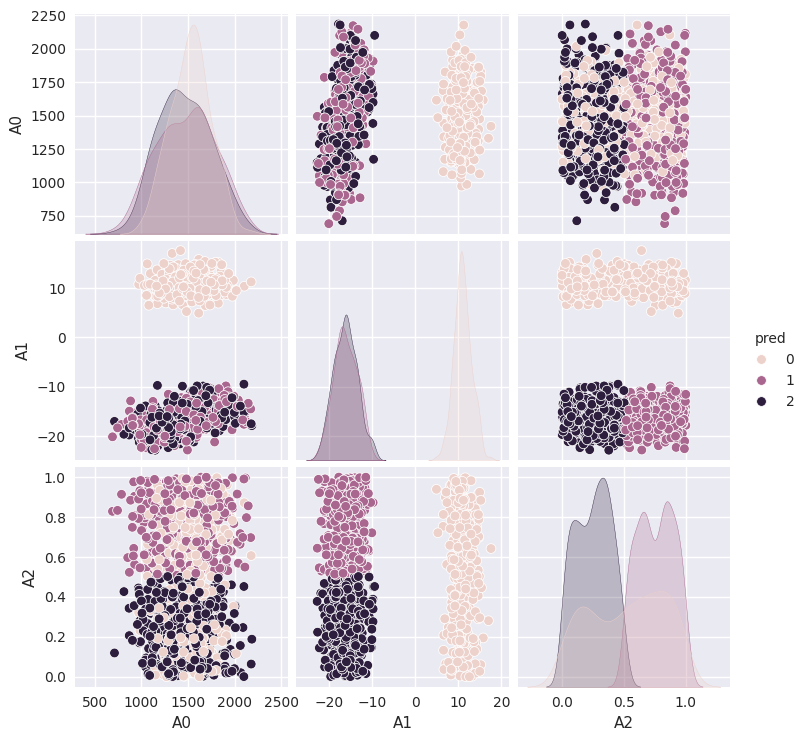

In [178]:
sns.pairplot(X.assign(pred=y_km), hue="pred")

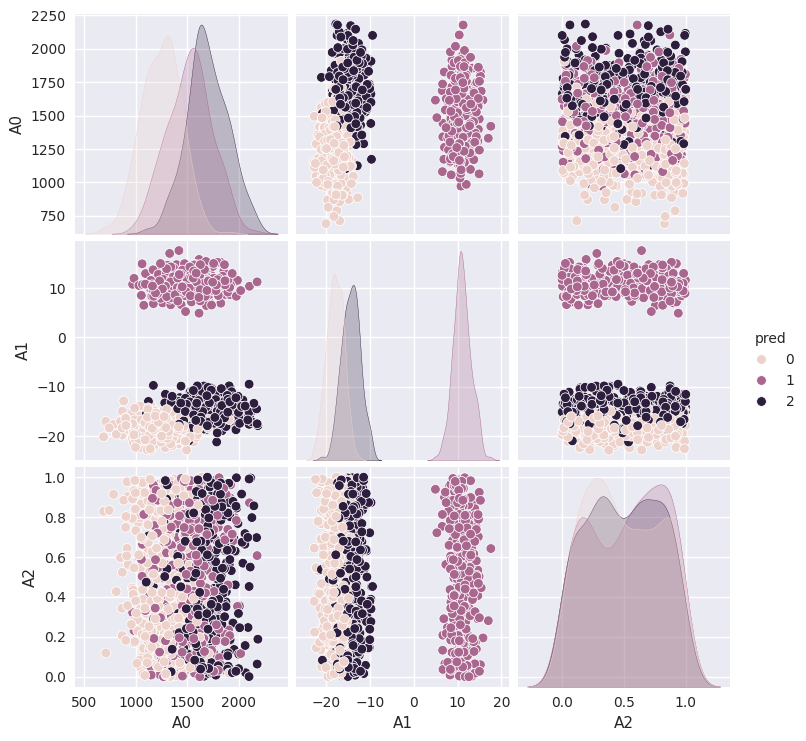

In [180]:
# Ground truth plot

sns.pairplot(X.assign(pred=y), hue="pred")